In [1]:
from allosaurus.app import read_recognizer
import numpy as np
import os
import re
from statistics import mean
import matplotlib.pyplot as plt

c:\Users\dorre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# In this notebook, we are going to find the best weight/coef for each of the 3 costs in the levenshtein distance algorithm by using the Genetic Algorithm

In [2]:
#This function will get the phone and the confidence score of that phone of an input audio file
#and then write them into a text file
def get_phones(filenames, model_name, output_file_name_extra, output_folder_path):
    recognizer = read_recognizer(model_name)

    #output file for writing the results
    output_fd = open(os.path.join(output_folder_path, model_name + output_file_name_extra), 'w', encoding='utf-8') 

    for i in range(len(filenames)):
        rec_out = recognizer.recognize(filenames[i], lang_id="pes", topk=2)
        if rec_out is None:
            continue
        #an example of an output (rec_out): 'r (0.871) l (0.121) | m (0.771) n (0.031) | ...'
        rec_out = rec_out.rstrip().split() #split on spaces

        #only the top phone is needed so for the above example we need 'r', 'm', ...
        phones = rec_out[::5]
        
        #only the top confidence is needed so for the above example we need '(0.871)', '(0.771)', ...
        #but we need the float numbers and not the strings so parentheses should be removed first and then the number be converted to float
        confidence = [float(re.sub(r'[()]', '', val)) for key,val in enumerate(rec_out) if key % 5 == 1] 

        output_fd.write(filenames[i])
        for i in range(len(phones)):
            output_fd.write(' ' + str(phones[i]) + ' ' + str(confidence[i]))
        output_fd.write('\n')

    output_fd.close()


In [11]:
output_folder_path = '.\\output-files\\phones-8s100p20allrb30-rb-10dB-with-k'

parent_test_path = '.\\test-ntns-10dB' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-test-ntns', output_folder_path)
print('ntns done')

parent_test_path = '.\\test-nts-10dB' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-test-nts', output_folder_path)
print('nts done')

parent_test_path = '.\\test-target-10dB' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-test-target', output_folder_path)
print('target done')

parent_test_path = '.\\validation-ntns-10dB' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-validation-ntns', output_folder_path)
print('ntns done')

parent_test_path = '.\\validation-nts-10dB' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-validation-nts', output_folder_path)
print('nts done')

parent_test_path = '.\\validation-target-10dB' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-validation-target', output_folder_path)
print('target done')

ntns done
nts done
target done
ntns done
nts done
target done


In [2]:
#list1: list of expected symbols
#list2: list of output symbols (output of allosaurus)
#conf: list of confidence for output symbols (output of allosaurus when k>=2)
def levenshteinDistance(list1, list2, ins_coef = 1, del_coef = 1, sub_coef = 1, conf = None):
    m = len(list1)
    n = len(list2)
    d = [[i] for i in range(1, m + 1)]   # d matrix rows
    d.insert(0, list(range(0, n + 1)))   # d matrix columns
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if list1[i - 1] == list2[j - 1]: #Python compares strings and characters the same way => each list element can be a single character or a string (word)
                substitutionCost = 0
            else:
                if conf is None:
                    substitutionCost = 1
                else:
                    substitutionCost = conf[j-1]
            if conf is None:
                d[i].insert(j, min(d[i - 1][j] + ins_coef * 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + del_coef * 1,                         #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + sub_coef * substitutionCost))     #substitution
            else: 
                d[i].insert(j, min(d[i - 1][j] + ins_coef * 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + del_coef * conf[j-1],                 #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + sub_coef * substitutionCost))     #substitution
    return d[-1][-1]

In [3]:
filenames = os.listdir('.\\output-files\\phones-8s100p20allrb30-rb-with-k')
input_files = []
for fname in filenames:
    input_files.append(os.path.join('output-files\\phones-8s100p20allrb30-rb-with-k', fname))
input_files

['output-files\\phones-8s100p20allrb30-rb-with-k\\8s100p20allrb30-test-ntns',
 'output-files\\phones-8s100p20allrb30-rb-with-k\\8s100p20allrb30-test-nts',
 'output-files\\phones-8s100p20allrb30-rb-with-k\\8s100p20allrb30-test-target',
 'output-files\\phones-8s100p20allrb30-rb-with-k\\8s100p20allrb30-validation-ntns',
 'output-files\\phones-8s100p20allrb30-rb-with-k\\8s100p20allrb30-validation-nts',
 'output-files\\phones-8s100p20allrb30-rb-with-k\\8s100p20allrb30-validation-target']

In [4]:
target_pho = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']

def fitness_func(solution, solution_idx):
    sol = solution.tolist()
    total_file = 0
    val1 = []
    val2 = []
    val3 = []
    thresh_range = np.arange(0, 15.05, 0.05)
    acc = []

    with open(input_files[3], encoding='utf-8') as file: #validation-ntns
        for line in file:
            total_file += 1
            res = line.rstrip().split( )
            pho = res[1::2]
            con_str = res[2::2]
            con = [float(x) for x in con_str]
            val1.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))
    
    with open(input_files[4], encoding='utf-8') as file: #validation-nts
        for line in file:
            total_file += 1
            res = line.rstrip().split( )
            pho = res[1::2]
            con_str = res[2::2]
            con = [float(x) for x in con_str]
            val2.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con)) 
    
    with open(input_files[5], encoding='utf-8') as file: #validation-target
        for line in file: 
            total_file += 1
            res = line.rstrip().split( )
            pho = res[1::2]
            con_str = res[2::2]
            con = [float(x) for x in con_str]
            val3.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))
    
    for thresh in thresh_range:
        correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
        acc.append(correct/total_file)
    
    fitness = max(acc)
    return fitness

In [5]:
import pygad

fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = 3 #3 coefs

keep_parents = 1

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       keep_parents=keep_parents,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = np.arange(0, 1.0001, 0.0001) )

c:\Users\dorre\AppData\Local\Programs\Python\Python39\lib\site-packages\pygad\pygad.py:522: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


In [6]:
ga_instance.run()

In [ ]:
ga_instance.plot_fitness()

In [8]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.6671 0.4334 0.7406]
Fitness value of the best solution = 0.9920544835414302


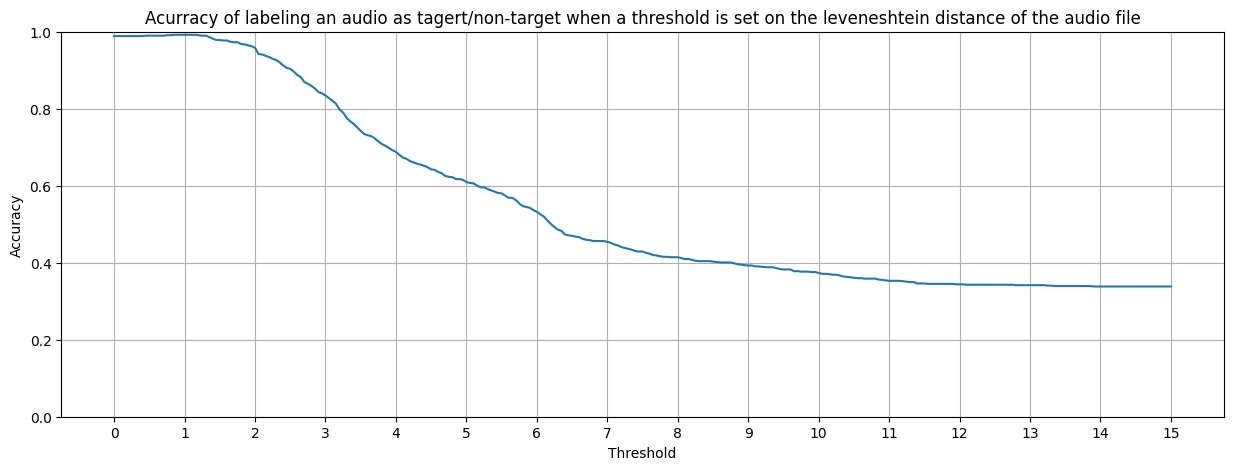

accuracy on the dev set at  0.85: 0.9920544835414302 


In [9]:
target_pho = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']
sol = [0.6671, 0.4334, 0.7406]

total_file = 0
val1 = []
val2 = []
val3 = []
thresh_range = np.arange(0, 15.05, 0.05)
acc = []

with open(input_files[3], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val1.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

with open(input_files[4], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val2.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con)) 

with open(input_files[5], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val3.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

for thresh in thresh_range:
    correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
    acc.append(correct/total_file)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(thresh_range,acc)
plt.xticks(range(0, 16), range(0, 16))
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Acurracy of labeling an audio as tagert/non-target when a threshold is set on the leveneshtein distance of the audio file')
plt.grid()   
plt.ylim([0.00, 1.0])  
plt.show()

an_array = np.array(acc)
index = np.argmax(an_array)
print("accuracy on the dev set at  {i:.2f}: {a} ".format(i = index*0.05, a = acc[index])) #remember to change index for test files

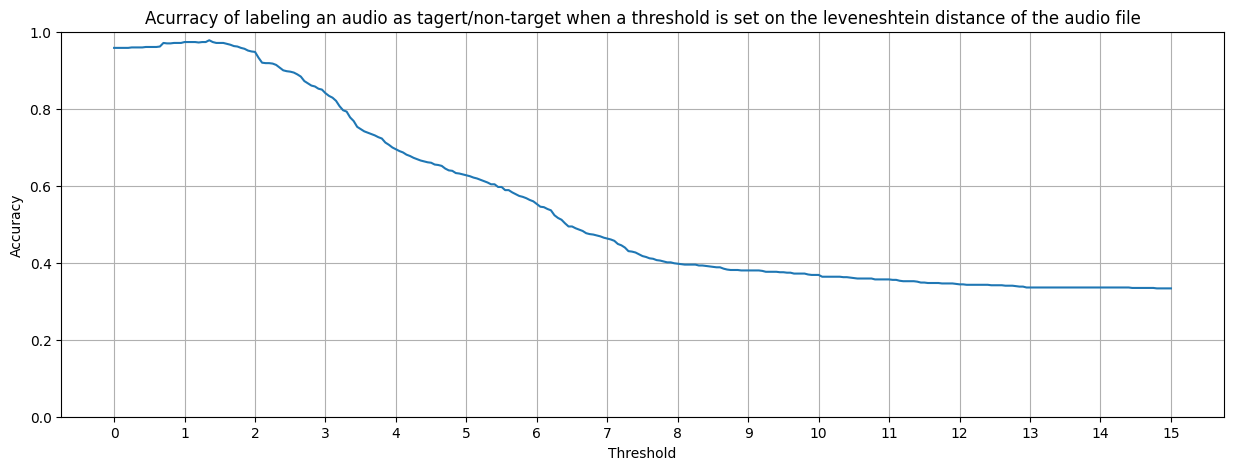

accuracy at 1.35: 0.9778554778554779
accuracy on the test set at 0.85:  0.9708624708624709


In [10]:
target_pho = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']
sol = [0.6671, 0.4334, 0.7406]

total_file = 0
val1 = []
val2 = []
val3 = []
thresh_range = np.arange(0, 15.05, 0.05)
acc = []

with open(input_files[0], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val1.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

with open(input_files[1], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val2.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con)) 

with open(input_files[2], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val3.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

for thresh in thresh_range:
    correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
    acc.append(correct/total_file)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(thresh_range,acc)
plt.xticks(range(0, 16), range(0, 16))
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Acurracy of labeling an audio as tagert/non-target when a threshold is set on the leveneshtein distance of the audio file')
plt.grid()   
plt.ylim([0.00, 1.0])  
plt.show()

an_array = np.array(acc)
index = np.argmax(an_array)
print("accuracy at {i:.2f}: {a}".format(i = index*0.05, a = acc[index])) #remember to change index for test files
print("accuracy on the test set at 0.85: ", acc[int(0.85 * 20)])

In [12]:
noisy_filenames = os.listdir('.\\output-files\\phones-8s100p20allrb30-rb-10dB-with-k')
noisy_input_files = []
for fname in filenames:
    noisy_input_files.append(os.path.join('output-files\\phones-8s100p20allrb30-rb-10dB-with-k', fname))
noisy_input_files

['output-files\\phones-8s100p20allrb30-rb-10dB-with-k\\8s100p20allrb30-test-ntns',
 'output-files\\phones-8s100p20allrb30-rb-10dB-with-k\\8s100p20allrb30-test-nts',
 'output-files\\phones-8s100p20allrb30-rb-10dB-with-k\\8s100p20allrb30-test-target',
 'output-files\\phones-8s100p20allrb30-rb-10dB-with-k\\8s100p20allrb30-validation-ntns',
 'output-files\\phones-8s100p20allrb30-rb-10dB-with-k\\8s100p20allrb30-validation-nts',
 'output-files\\phones-8s100p20allrb30-rb-10dB-with-k\\8s100p20allrb30-validation-target']

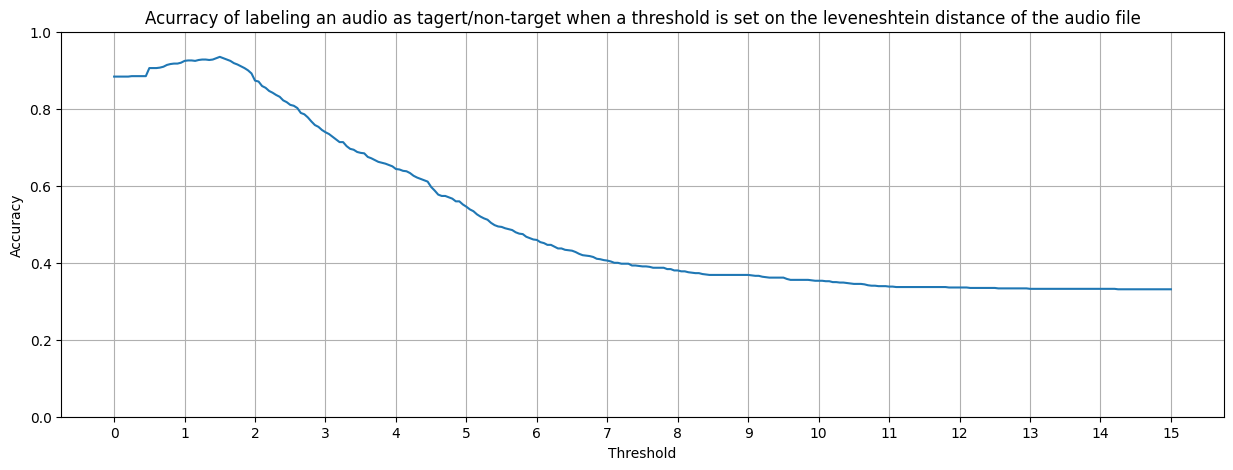

accuracy at 1.50: 0.9347319347319347
accuracy on the noisy test set at 0.85:  0.9172494172494172


In [16]:
target_pho = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']
sol = [0.496,0.43,0.735]


total_file = 0
val1 = []
val2 = []
val3 = []
thresh_range = np.arange(0, 15.05, 0.05)
acc = []

with open(noisy_input_files[0], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val1.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

with open(noisy_input_files[1], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val2.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con)) 

with open(noisy_input_files[2], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val3.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

for thresh in thresh_range:
    correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
    acc.append(correct/total_file)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(thresh_range,acc)
plt.xticks(range(0, 16), range(0, 16))
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Acurracy of labeling an audio as tagert/non-target when a threshold is set on the leveneshtein distance of the audio file')
plt.grid()   
plt.ylim([0.00, 1.0])  
plt.show()

an_array = np.array(acc)
index = np.argmax(an_array)
print("accuracy at {i:.2f}: {a}".format(i = index*0.05, a = acc[index])) #remember to change index for test files
print("accuracy on the noisy test set at 0.85: ", acc[int(0.85 * 20)])

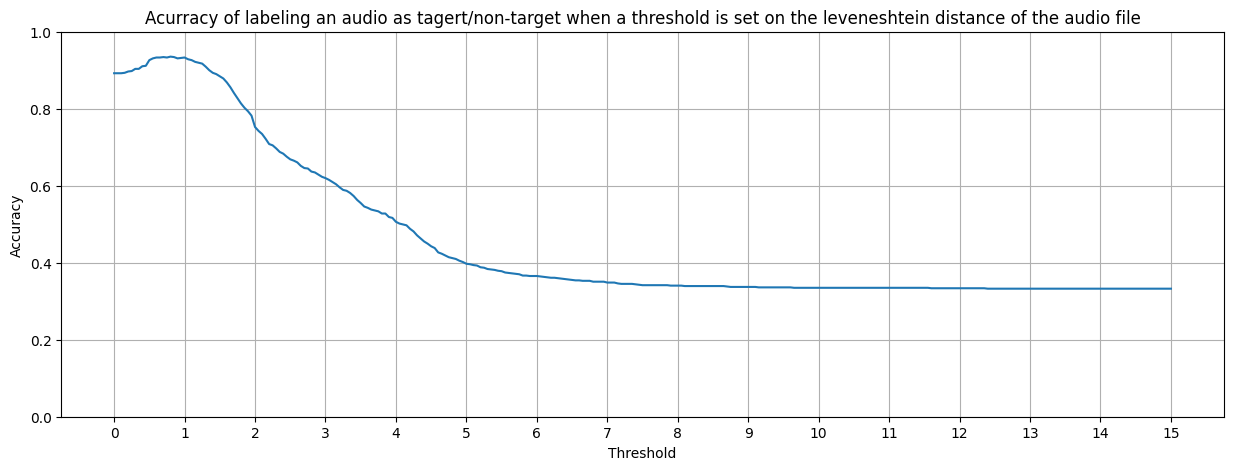

accuracy at 0.80: 0.9353007945516458
accuracy on the noisy dev set at 0.6:  0.9330306469920545


In [20]:
target_pho = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']
sol = [0.5,0.3, 0.4]


total_file = 0
val1 = []
val2 = []
val3 = []
thresh_range = np.arange(0, 15.05, 0.05)
acc = []

with open(noisy_input_files[3], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val1.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

with open(noisy_input_files[4], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val2.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con)) 

with open(noisy_input_files[5], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split( )
        pho = res[1::2]
        con_str = res[2::2]
        con = [float(x) for x in con_str]
        val3.append(levenshteinDistance(target_pho, pho, ins_coef = sol[0], del_coef = sol[1], sub_coef = sol[2], conf = con))

for thresh in thresh_range:
    correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
    acc.append(correct/total_file)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(thresh_range,acc)
plt.xticks(range(0, 16), range(0, 16))
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Acurracy of labeling an audio as tagert/non-target when a threshold is set on the leveneshtein distance of the audio file')
plt.grid()   
plt.ylim([0.00, 1.0])  
plt.show()

an_array = np.array(acc)
index = np.argmax(an_array)
print("accuracy at {i:.2f}: {a}".format(i = index*0.05, a = acc[index])) #remember to change index for test files
print("accuracy on the noisy dev set at 0.6: ", acc[int(0.6 * 20)])